Name : Chean Botum  ITE-G8-A


**Fruit Image Classification**



## Importing the Libraries











In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import os
import pathlib
from zipfile import ZipFile
import PIL

import tensorflow as tf

In [ ]:
dataset_url = "https://storage.googleapis.com/kaggle-data-sets/5857%2F1166105%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1599228654&Signature=BGqY%2BsLSb5lp2kyyDV5r859MClfo9qj0a5j056di3Pu26vyMmUKBQ4H%2BAGdeB%2FzhxQp2MsFChCxJbt0JzpYnV%2FBCNcQLpVuJuhh6dFnhuOW0DFhoW9AzsucGTv1hu2uYUBpjxu6pgnMuq4ERBSC6CsSQ8s4gCH9VKUjXj%2Fdq1tdZJPxL%2B3DaLocKswWgIyXm02OtdyYlSjAudIDQ4QEniLtWDhK10SKpMej4rR41%2F8dn%2BoxRrL668KXYSeIuI8aVxGpwswV%2BQW0xIk8hfGHwU4bJ8YO8iQA0TyVsx%2BcurL5%2BT6pJ0W96sqN4p804EcVHv4ByGrm7q%2F4wENkdbwbCZA%3D%3D"

In [ ]:
data_dir = tf.keras.utils.get_file("/content/fruit.zip", origin=dataset_url)

796745728/796742678 [==============================] - 33s 0us/step


In [ ]:
zf = ZipFile(data_dir)
zf.extractall("/content")

In [ ]:
train_dir = pathlib.Path("/content/fruits-360/Training")
test_dir = pathlib.Path("/content/fruits-360/Test")

In [ ]:
image_count = len(list(train_dir.glob('*/*.jpg')))
image_count

67692

# Visualization

snippet demonstrates how to visualize a subset of images from a specific category using the matplotlib library

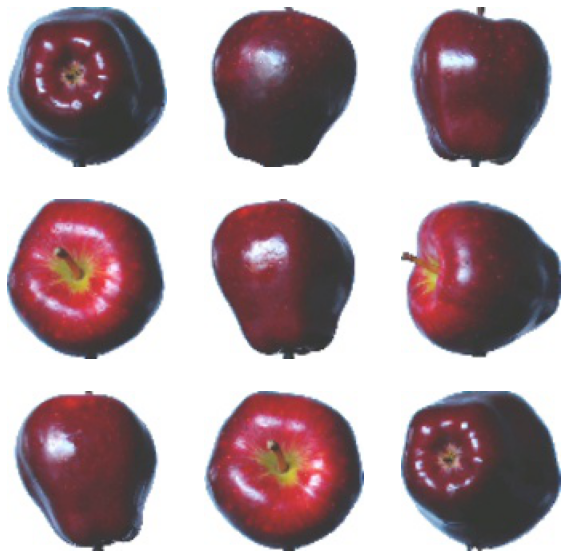

In [ ]:
fruits = list(train_dir.glob('Apple Red Delicious/*.jpg'))

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(str(fruits[i]))
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [ ]:
batch_size = 32
img_height = 100
img_width = 100

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)

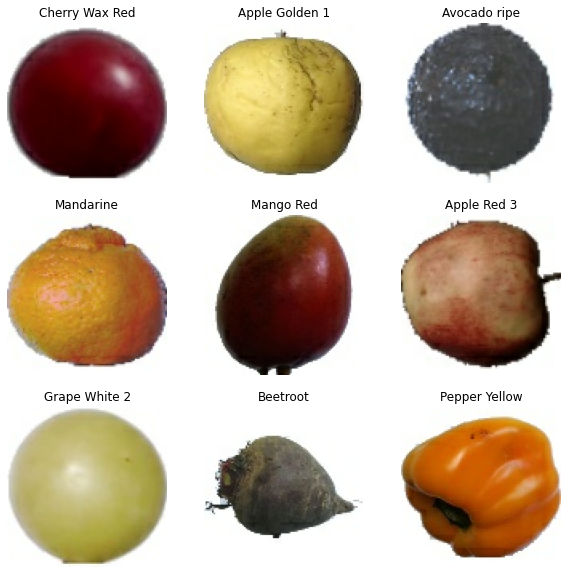

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 100, 100, 3)
(32,)


# Preprocessing/Setting Up Base Model

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [ ]:
base_model = tf.keras.applications.resnet.ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

94773248/94765736 [==============================] - 7s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

# Building the Model

In [ ]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 100, 100, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 100, 100, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)             

# Training the Model

In [ ]:
model.evaluate(val_ds)

424/424 [==============================] - 103s 244ms/step - loss: 6.1080 - accuracy: 0.0061


[6.107956886291504, 0.006057024467736483]

In [ ]:
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/10
1693/1693 [==============================] - 75s 44ms/step - loss: 1.4485 - accuracy: 0.6632 - val_loss: 0.5659 - val_accuracy: 0.9029
Epoch 2/10
1693/1693 [==============================] - 67s 40ms/step - loss: 0.2779 - accuracy: 0.9365 - val_loss: 0.2861 - val_accuracy: 0.9514
Epoch 3/10
1693/1693 [==============================] - 67s 40ms/step - loss: 0.1425 - accuracy: 0.9696 - val_loss: 0.1842 - val_accuracy: 0.9699
Epoch 4/10
1693/1693 [==============================] - 67s 40ms/step - loss: 0.0883 - accuracy: 0.9823 - val_loss: 0.1391 - val_accuracy: 0.9736
Epoch 5/10
1693/1693 [==============================] - 67s 40ms/step - loss: 0.0619 - accuracy: 0.9879 - val_loss: 0.1085 - val_accuracy: 0.9784
Epoch 6/10
1693/1693 [==============================] - 67s 39ms/step - loss: 0.0463 - accuracy: 0.9907 - val_loss: 0.0923 - val_accuracy: 0.9810
Epoch 7/10
1693/1693 [==============================] - 67s 40ms/step - loss: 0.0352 - accuracy: 0.9935 - val_loss: 0.0785 -

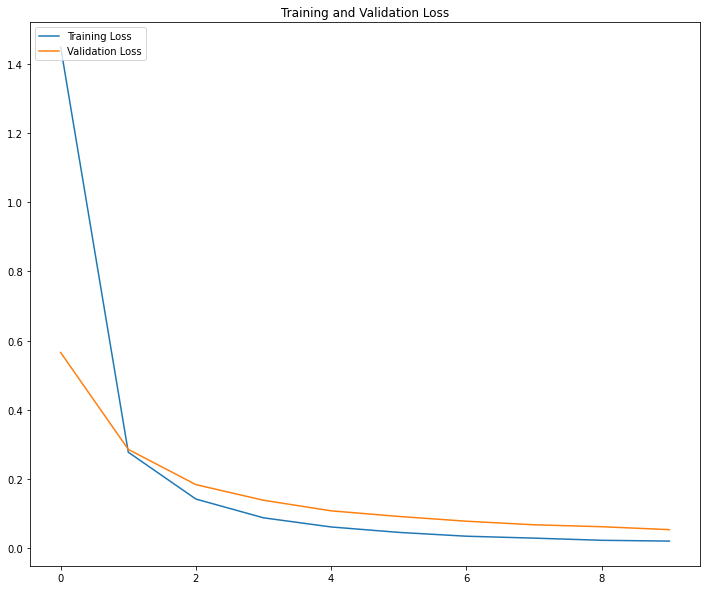

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
np.argmin(val_loss)

9